<a href="https://colab.research.google.com/github/Carolinsrainbow/UC_SistemasRecomendadores/blob/main/Ayudant%C3%ADa3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ayudantia 3 - MAN3160



**Profesor**: Denis Parra

**Ayudante**: Nicolas SUmonte


## Descarga del dataset

Nuevamente, se utilizará el dataset MovieLens-100k para esta tarea.

In [ ]:
# !pip install deepctr-torch

In [ ]:
# !pip install torch

In [ ]:
!pip install wget
!pip install zipfile36
!pip3 install implicit --upgrade
!python -m wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!pip install deepctr-torch
!pip install tensorflow

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=381ff2c1a612e20ee9388ada8c307fba8e53584f93ae2776c30278ba0e848b2e
  Stored in directory: /root/.cache/pip/wheels/40/b3/0f/a40dbd1c6861731779f62cc4babcb234387e11d697df70ee97
Successfully built wget
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 35.2 MB/s eta 0:00:00

Saved under ml-100k.zip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import zipfile
with zipfile.ZipFile("ml-100k.zip", 'r') as zip_ref:
    zip_ref.extractall(".")

In [ ]:
# Pueden importar más librerías si es necesario
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import implicit
import scipy.sparse as sparse
import time
import numpy as np
import pandas as pd
import torch

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score

from deepctr_torch.inputs import SparseFeat, VarLenSparseFeat, get_feature_names
from deepctr_torch.models import DeepFM

import seaborn as sns
from itertools import product

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from tabulate import tabulate

In [ ]:
def split(x):
    key_ans = x.split('|')
    for key in key_ans:
        if key not in key2index:
            # Notice : input value 0 is a special "padding",so we do not use 0 to encode valid feature for sequence input
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

In [ ]:
dir_train = 'ml-100k'

# Generamos los títulos de las columnas del archivo items.

columns = ['itemid', 'title', 'release_date', 'video_release_date', \
           'IMDb_URL', 'unknown', 'Action', 'Adventure', 'Animation', \
           'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
           'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', \
           'Thriller', 'War', 'Western']

In [ ]:
df = pd.read_csv(f'{dir_train}/u.data',
                         sep='\t',
                         names=['userid', 'itemid', 'rating', 'timestamp'],
                         header=None)

In [ ]:
df_items = pd.read_csv(f'{dir_train}/u.item',
                        sep='|',
                        index_col=0,
                        names = columns,
                        header=None,
                        encoding='latin-1')

In [ ]:
columns_user = ['userid', 'age', 'gender', 'occupation', 'zip_code']

In [ ]:
df_users = pd.read_csv(f'{dir_train}/u.user',
                        sep='|',
                        index_col=0,
                        names = columns_user,
                        header=None,
                        encoding='latin-1')

df_users = df_users.reset_index()
df_items = df_items.reset_index()

In [ ]:
df_total = pd.merge(df, df_users, on='userid')
df_total = pd.merge(df_total, df_items, on='itemid')

In [ ]:
def combine_genres(row):
    genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
    return '|'.join([col for col, val in row.items() if val == 1 and col in genres])

In [ ]:
df_total['genres'] = df_total.apply(combine_genres, axis=1)

In [ ]:
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', \
              'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
df_total = df_total.drop(genres, axis=1)

In [ ]:
df_total.sort_values(by='timestamp').head(10)

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres
214,259,255,4,874724710,21,M,student,48823,My Best Friend's Wedding (1997),20-Jun-1997,NaN,http://us.imdb.com/M/title-exact?My+Best+Frien...,0,Comedy|Romance
83965,259,286,4,874724727,21,M,student,48823,"English Patient, The (1996)",15-Nov-1996,NaN,http://us.imdb.com/M/title-exact?English%20Pat...,0,Drama|Romance|War
43027,259,298,4,874724754,21,M,student,48823,Face/Off (1997),27-Jun-1997,NaN,http://us.imdb.com/M/title-exact?Face/Off+(1997),0,Action|Sci-Fi|Thriller
21396,259,185,4,874724781,21,M,student,48823,Psycho (1960),01-Jan-1960,NaN,http://us.imdb.com/M/title-exact?Psycho%20(1960),0,Horror|Romance|Thriller
82655,259,173,4,874724843,21,M,student,48823,"Princess Bride, The (1987)",01-Jan-1987,NaN,http://us.imdb.com/M/title-exact?Princess%20Br...,0,Action|Adventure|Comedy|Romance
1766,259,772,4,874724882,21,M,student,48823,Kids (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Kids%20(1995),0,Drama
10891,259,108,4,874724882,21,M,student,48823,Kids in the Hall: Brain Candy (1996),12-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Kids%20in%20t...,0,Comedy
26399,259,288,3,874724905,21,M,student,48823,Scream (1996),20-Dec-1996,NaN,http://us.imdb.com/M/title-exact?Scream%20(1996),0,Horror|Thriller
85297,259,928,4,874724937,21,M,student,48823,"Craft, The (1996)",26-Apr-1996,NaN,"http://us.imdb.com/M/title-exact?Craft,%20The%...",0,Drama|Horror
159,259,117,4,874724988,21,M,student,48823,"Rock, The (1996)",07-Jun-1996,NaN,"http://us.imdb.com/M/title-exact?Rock,%20The%2...",0,Action|Adventure|Thriller


##Análisis de características de contenido.
 Esta primera actividad se tratará de seleccionar los datos de contenido que usarán y realicen un análisis de ello. Lo que deben hacer es:

## Respuesta

In [ ]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   userid              100000 non-null  int64  
 1   itemid              100000 non-null  int64  
 2   rating              100000 non-null  int64  
 3   timestamp           100000 non-null  int64  
 4   age                 100000 non-null  int64  
 5   gender              100000 non-null  object 
 6   occupation          100000 non-null  object 
 7   zip_code            100000 non-null  object 
 8   title               100000 non-null  object 
 9   release_date        99991 non-null   object 
 10  video_release_date  0 non-null       float64
 11  IMDb_URL            99987 non-null   object 
 12  unknown             100000 non-null  int64  
 13  genres              100000 non-null  object 
dtypes: float64(1), int64(6), object(7)
memory usage: 10.7+ MB


**Características de los Ítems:**

- **Género de la Película (genre):** Permite realizar recomendaciones de acuerdo con las calificaciones previas del usuario ha a ciertos géneros, por lo tanto es más probable seleccionar películas similares en el mismo género.

- **Fecha de Lanzamiento de la Película (release_date):** Permite identificar películas recientes o clásicas, usuarios pueden preferir películas más recientes, mientras que otros pueden preferir películas antiguas.

**Características del Usuario:**

- **Edad (age):** Las preferencias por las películas pueden variar según la edad, por lo que conocer la edad de un usuario podría ayudar a realizar recomendaciones más personalizadas. Por ejemplo, en el gráfico presentado *Comportamiento edad, sexo de los usuarios vs genero de la película*, las películas de genero *Documentales* y *Film Noir* (caracterizado por su estilo visual oscuro y sombrío), la barra se encuentra hacia personas de mayor edad.

- **Género (gender):** Algunas películas pueden ser más populares entre un género especifico. Por ejemplo, en el gráfico presentado *Comportamiento edad, sexo de los usuarios vs genero de la película*, las mujeres prefieren las películas de tipo *Documentales* y los hombres *Film Noir*.

#### Género de la Película (genres)
Hay 18 clasificaciones de genero de películas. La mayoría de las películas pertenecen al género Drama y Comedia.

In [ ]:
genres_movies_dict = {}

for index, row in df_total.iterrows():
    item_id = row['itemid']
    genres = row['genres'].split('|')  # Divide los géneros por "|"
    genres_movies_dict[item_id] = genres

all_genres = []
for item_id, genres in genres_movies_dict.items():
    all_genres.extend(genres)

<ipython-input-71-b26200ab36aa>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=all_genres, order=pd.Series(all_genres).value_counts().index, palette='Set3')


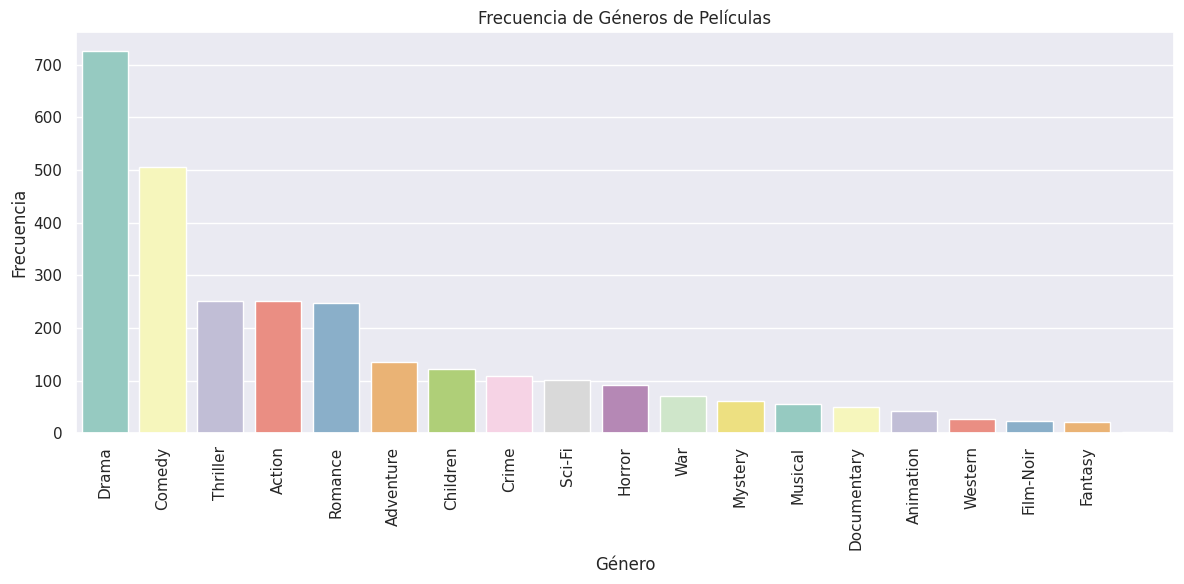

In [ ]:
plt.figure(figsize=(12, 6))
sns.set(style='darkgrid')
sns.countplot(x=all_genres, order=pd.Series(all_genres).value_counts().index, palette='Set3')
plt.xlabel('Género')
plt.ylabel('Frecuencia')
plt.title('Frecuencia de Géneros de Películas')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

#### Fecha de Lanzamiento de la Película (release_date)

Los registros sin fecha de lanzamiento se imputan con la fecha *1900-01-01*.<br>
El 25%, 50% y 75%  de las películas corresponden a fechas de lanzamiento inferior a 1986, 1994 y 1996 respectivamente. <br>
La película más reciente es del año 1998.<br>
Clasificaremos las películas de acuerdo con su década, películas de la época de los 80's y películas de los 90's.<br>
Quedando finalmente, que el 70% de las peliculas son de la epoca de los 90's y el 30% de los 80's

In [ ]:
df_total['release_date'].fillna('01-Jan-1900', inplace=True)

<ipython-input-72-483b862a2f2f>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_total['release_date'].fillna('01-Jan-1900', inplace=True)


In [ ]:
pd.to_datetime(df_total['release_date'], format='%d-%b-%Y').dt.year.astype('int').describe()

,release_date
count,100000.000000
mean,1987.948300
std,14.179457
min,1900.000000
25%,1986.000000
50%,1994.000000
75%,1996.000000
max,1998.000000


In [ ]:
df_total['dec_release'] = pd.to_datetime(df_total['release_date'], format='%d-%b-%Y').dt.year.astype('int').apply(lambda x: '80s' if x <= 1989 else '90s')

In [ ]:
tabla_dec_release  = df_total.groupby(['dec_release']).size().reset_index().rename(columns={0: 'conteo'})
tabla_dec_release['perc'] = tabla_dec_release['conteo']  / tabla_dec_release['conteo'].sum()
tabla_dec_release

,dec_release,conteo,perc
0,80s,29555,0.29555
1,90s,70445,0.70445


#### Distribución genero
El 74% de los usuarios son hombres y solo el 25% son mujeres.

In [ ]:
tabla_gender  = df_total.groupby(['gender']).size().reset_index().rename(columns={0: 'conteo'})
tabla_gender['perc'] = tabla_gender['conteo']  / tabla_gender['conteo'].sum()
tabla_gender

,gender,conteo,perc
0,F,25740,0.2574
1,M,74260,0.7426


#### Distribución edad

La edad minima observada es de 7 años, el 50% de los usuarios tienen 30 años o menos, la maxima edad observada es 70 años.

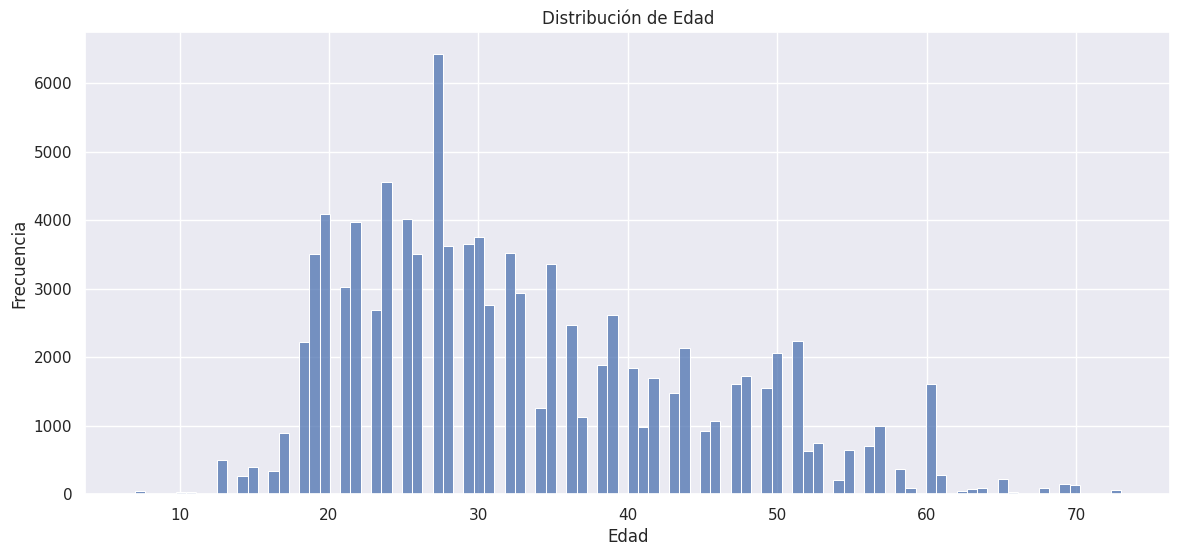

In [ ]:
fig, ax0 = plt.subplots(figsize=(14,6))
sns.histplot(data=df_total, x="age")

plt.title("Distribución de Edad")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")

plt.show()

In [ ]:
df_total['age'].describe()

,age
count,100000.000000
mean,32.969850
std,11.562623
min,7.000000
25%,24.000000
50%,30.000000
75%,40.000000
max,73.000000


#### Grafico del Comportamiento edad, sexo de los usuarios vs genero de la película

<ipython-input-79-e5db89ae0460>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


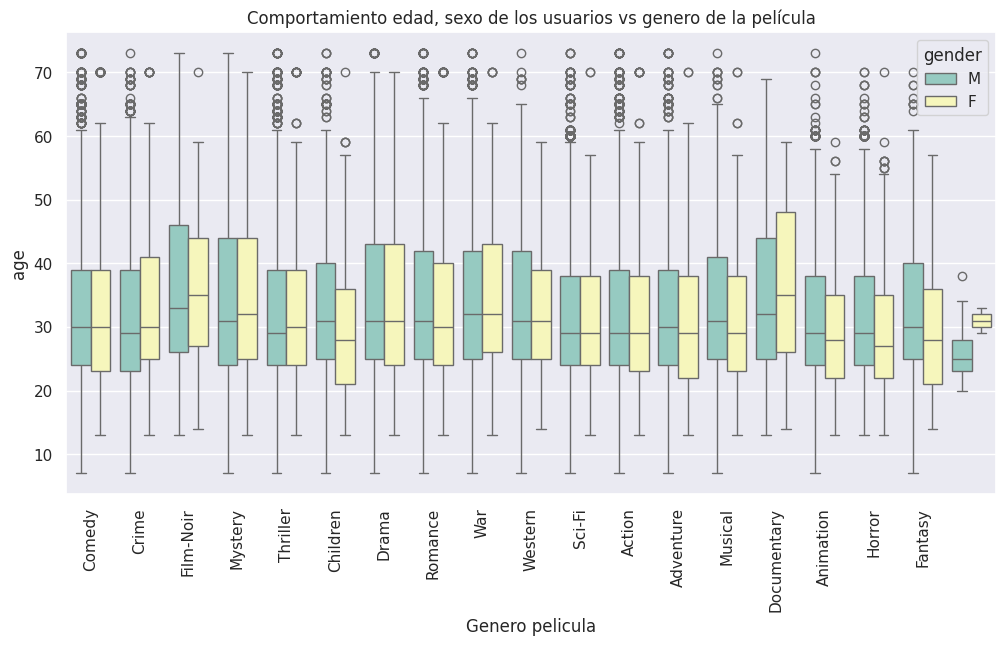

In [ ]:
df_total_aux = df_total.copy()
df_total_aux = df_total_aux[['genres', 'age', 'gender']]

df_total_aux['genero_pelicula'] = df_total_aux['genres'].str.split('|')
df_total_aux = df_total_aux.explode('genero_pelicula')

plt.figure(figsize=(12, 6))
ax = sns.boxplot(x="genero_pelicula", y="age", hue="gender", data=df_total_aux, palette="Set3")  # RUN PLOT
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

plt.title("Comportamiento edad, sexo de los usuarios vs genero de la película")
plt.xlabel("Genero pelicula")
plt.show()
plt.clf()
plt.close()

#Generación Caracteristica Contextual



* A partir del timestamp (ya que este es la única característica contextual del dataset), capture otra característica contextual que pueda ser utilizada en el entrenamiento (que no sea una división de mañana/tarde/noche).
* Genere una hipótesis de cómo podría influir la variable contextual en la recomendación. (Por ejemplo, una hipótesis podría ser que en la noche, se deberían recomendar una mayor cantidad de películas de terror).

**Contexto:** Indica durante que etapa de celebración fue vista la película.<br>
**Hipotesis:** Durante las temporadas de celebración, los usuarios tienden a buscar y disfrutar de películas que están temáticamente relacionadas con la festividad en cuestión <br>

- Año Nuevo: Enero
- San Valentin:Febrero
- Mes de la madre: Mayo
- Mes del padre: Junio
- Hallowen: Octubre
- Navidad: Diciembre
- Otro: Marzo, Abril, Julio, Agosto, Septiembre, Noviembre


In [ ]:
def agrupar_por_celebracion(mes):
    if mes == 5:
        return "Mes de la Madre"
    elif mes == 6:
        return "Mes del Padre"
    elif mes == 1:
        return "Año Nuevo"
    elif mes == 2:
        return "Día de San Valentín"
    elif mes == 10:
        return "Halloween"
    elif mes == 12:
        return "Navidad"
    else:
        return "Otro"

df_total['movie_celebration'] =  pd.to_datetime(df_total['timestamp'], unit='s').dt.month.apply(agrupar_por_celebracion)

In [ ]:
df_total

,userid,itemid,rating,timestamp,age,gender,occupation,zip_code,title,release_date,video_release_date,IMDb_URL,unknown,genres,dec_release,movie_celebration
0,196,242,3,881250949,49,M,writer,55105,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,Comedy,90s,Navidad
1,186,302,3,891717742,39,F,executive,00000,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,Crime|Film-Noir|Mystery|Thriller,90s,Otro
2,22,377,1,878887116,25,M,writer,40206,Heavyweights (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Heavyweights%...,0,Children|Comedy,90s,Otro
3,244,51,2,880606923,28,M,technician,80525,Legends of the Fall (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Legends%20of%...,0,Drama|Romance|War|Western,90s,Otro
4,166,346,1,886397596,47,M,educator,55113,Jackie Brown (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?imdb-title-11...,0,Crime|Drama,90s,Día de San Valentín
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,880,476,3,880175444,13,M,student,83702,"First Wives Club, The (1996)",14-Sep-1996,NaN,http://us.imdb.com/M/title-exact?First%20Wives...,0,Comedy,90s,Otro
99996,716,204,5,879795543,36,F,administrator,44265,Back to the Future (1985),01-Jan-1985,NaN,http://us.imdb.com/M/title-exact?Back%20to%20t...,0,Comedy|Sci-Fi,80s,Otro
99997,276,1090,1,874795795,21,M,student,95064,Sliver (1993),01-Jan-1993,NaN,http://us.imdb.com/M/title-exact?Sliver%20(1993),0,Thriller,90s,Otro
99998,13,225,2,882399156,47,M,educator,29206,101 Dalmatians (1996),27-Nov-1996,NaN,http://us.imdb.com/M/title-exact?101%20Dalmati...,0,Children|Comedy,90s,Navidad


#DEEP-FM



1. **Modelo de Factorización Profunda (Deep Factorization Model)**:
DeepFM combina dos componentes principales: un modelo de factorización y una red neuronal profunda. La idea detrás de la factorización es representar a los usuarios y los elementos recomendados (como películas o productos) en un espacio de características (vectores de números) donde las similitudes entre ellos se pueden calcular fácilmente.
2. **Factorización de Interacción (Factorization Machine):**
La parte de factorización en DeepFM es similar a un modelo llamado Factorization Machine (FM). FM es útil para capturar las interacciones entre diferentes características (por ejemplo, la preferencia de un usuario por ciertos géneros de películas). DeepFM utiliza FM para aprender las interacciones entre las características de entrada de manera eficiente.
3. **Red Neuronal Profunda**:
Además de la parte de factorización, DeepFM también tiene una red neuronal profunda que aprende representaciones más complejas de los datos. Esta red neuronal puede aprender patrones más sofisticados y no lineales en los datos de entrada.
4. **Combinación de Factorización y Redes Neuronales:**
Lo interesante de DeepFM es que combina tanto la factorización como las capacidades de aprendizaje profundo en un solo modelo. Esto le permite capturar tanto las interacciones lineales como no lineales entre las características de entrada, lo que puede mejorar la precisión de las recomendaciones.
5. **Entrenamiento y Optimización:**
Durante el entrenamiento, DeepFM ajusta sus parámetros (los pesos de la red neuronal y las matrices de factorización) para minimizar una función de pérdida, que mide cuán bien el modelo puede predecir las preferencias del usuario para los elementos recomendados.

## Metrica Auc

**Área bajo la Curva ROC (AUC):**
La curva ROC es una representación gráfica de la tasa de verdaderos positivos (sensibilidad) frente a la tasa de falsos positivos (1 - especificidad) para diferentes umbrales de clasificación. El AUC mide el área bajo esta curva y proporciona una medida de la capacidad de un modelo para discriminar entre las clases positiva y negativa. Cuanto mayor sea el AUC, mejor será el modelo en términos de capacidad predictiva.

Para calcular esta metrica es necesario BINARIZAR nuestra variable de interes debido a que:

1. **Formato de la métrica:** La métrica AUC se basa en la comparación de las clasificaciones predichas por el modelo con las clasificaciones reales (etiquetas de clase). Para que esta comparación sea posible, necesitamos tener etiquetas binarias (por ejemplo, 1 para relevante y 0 para no relevante) que representen si un usuario considera un elemento como relevante o no.
2. **Evaluación de relevancia:** En un sistema de recomendación, los ratings continuos proporcionados por los usuarios pueden representar diferentes niveles de preferencia o relevancia hacia los elementos recomendados. Sin embargo, para la métrica AUC, necesitamos definir un criterio claro para determinar qué ratings considerar como relevantes y cuáles como no relevantes. La binarización nos permite establecer este umbral de relevancia de manera consistente.
3. **Comparación con las predicciones del modelo:** Una vez que hemos binarizado los ratings en clases de relevante y no relevante, podemos comparar las predicciones continuas del modelo (que representan la probabilidad de relevancia) con estas clases binarias. Esto nos permite calcular la tasa de verdaderos positivos y la tasa de falsos positivos necesarias para construir la curva ROC y calcular el AUC.

In [ ]:
def split(x):
    key_ans = x.split('|')
    #Divide la cadena usando '|' como separador
    for key in key_ans:
        if key not in key2index:
          #Asigna un índice único a cada género si no existe ya en el diccionario key2index
            key2index[key] = len(key2index) + 1
    return list(map(lambda x: key2index[x], key_ans))

#Inicializa un diccionario vacío key2index que servirá como mapeo de géneros a índices numéricos
key2index = {}
genres_list = list(map(split, df_total['genres'].values))
genres_length = np.array(list(map(len, genres_list)))
max_len = max(genres_length)
#Usa pad_sequences para rellenar las listas con ceros al final (padding='post') hasta que todas tengan la misma longitud (max_len)
genres_list = pad_sequences(genres_list, maxlen=max_len, padding='post', )


array([[ 1,  0,  0,  0,  0,  0],
       [ 2,  3,  4,  5,  0,  0],
       [ 6,  1,  0,  0,  0,  0],
       ...,
       [ 5,  0,  0,  0,  0,  0],
       [ 6,  1,  0,  0,  0,  0],
       [10,  0,  0,  0,  0,  0]], dtype=int32)

In [ ]:
key2index

{'Comedy': 1,
 'Crime': 2,
 'Film-Noir': 3,
 'Mystery': 4,
 'Thriller': 5,
 'Children': 6,
 'Drama': 7,
 'Romance': 8,
 'War': 9,
 'Western': 10,
 'Sci-Fi': 11,
 'Action': 12,
 'Adventure': 13,
 'Musical': 14,
 'Documentary': 15,
 'Animation': 16,
 'Horror': 17,
 'Fantasy': 18,
 '': 19}

In [ ]:
genres_list[1000]

array([1, 8, 0, 0, 0, 0], dtype=int32)

### Primer Modelo: usuario, item y rating

In [ ]:
# Se realiza una copia del DataFrame df_total y se seleccionan las columnas 'userid', 'itemid' y 'rating'
df1 = df_total.copy()
df1 = df1[['userid', 'itemid', 'rating']]

# Se definen las características dispersas (sparse features) y el objetivo
sparse_features = ['userid', 'itemid']
target = ['rating']

# Se aplica la codificación de etiquetas (Label Encoding) a las características dispersas (aca es numerico siempre, pero pueden haber casos donde pasemos strings a numeros)
for feat in sparse_features:
    # Se crea un objeto LabelEncoder
    lbe = LabelEncoder()
    # Se aplica el Label Encoding a la columna correspondiente
    df1[feat] = lbe.fit_transform(df1[feat])

# El DataFrame df1 es modificado después de aplicar el Label Encoding
df1


,userid,itemid,rating
0,195,241,3
1,185,301,3
2,21,376,1
3,243,50,2
4,165,345,1
...,...,...,...
99995,879,475,3
99996,715,203,5
99997,275,1089,1
99998,12,224,2


In [ ]:
# Definición de características fijas
fixlen_feature_columns = [SparseFeat(feat, df1[feat].nunique()) for feat in sparse_features]
print(fixlen_feature_columns)

[SparseFeat(name='userid', vocabulary_size=943, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='userid', group_name='default_group'), SparseFeat(name='itemid', vocabulary_size=1682, embedding_dim=4, use_hash=False, dtype='int32', embedding_name='itemid', group_name='default_group')]


In [ ]:
# Obtención de nombres de características
feature_names = get_feature_names(fixlen_feature_columns)

# División de datos de entrenamiento y prueba
train, test = train_test_split(df1, test_size=0.2)
train_model_input = {name: train[name] for name in feature_names}
test_model_input = {name: test[name] for name in feature_names}

# Selección del dispositivo de cálculo
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('CUDA disponible...')
    device = 'cuda:0'

# Definición de valores de hiperparámetros
epochs_values = [8, 10, 12]
batch_size_values = [128, 256, 512]

# Inicialización de variables para el mejor MSE y los mejores hiperparámetros
best_mse = float('inf')
best_hyperparameters = {}

# Búsqueda de hiperparámetros óptimos
for epochs, batch_size in product(epochs_values, batch_size_values):

    # Creación del modelo DeepFM con los hiperparámetros actuales
    #Crea un modelo DeepFM para predicción de ratings (tarea de regresión)
    model = DeepFM(fixlen_feature_columns, fixlen_feature_columns, task='regression', device=device)
    model.compile("adam", "mse", metrics=['mse'])

    #Compila el modelo con optimizador Adam y función de pérdida MSE
    history = model.fit(train_model_input, train[target].values, batch_size=batch_size, epochs=epochs,
                        verbose=2, validation_split=0.2)

    # Predicción en datos de prueba
    y_pred = model.predict(test_model_input, batch_size=batch_size)
    mse = mean_squared_error(test[target].values, y_pred)
    #Si el MSE es mejor que el mejor encontrado hasta ahora, actualiza best_mse y best_hyperparameters
    # Actualización de los mejores hiperparámetros si se encuentra un MSE mejor
    if mse < best_mse:
        best_mse = mse
        best_hyperparameters = {'epochs': epochs, 'batch_size': batch_size}


CUDA disponible...
cuda:0
Train on 64000 samples, validate on 16000 samples, 500 steps per epoch
Epoch 1/8
3s - loss:  1.4790 - mse:  1.4790 - val_mse:  0.9057
Epoch 2/8
5s - loss:  0.8812 - mse:  0.8812 - val_mse:  0.8946
Epoch 3/8
3s - loss:  0.8680 - mse:  0.8680 - val_mse:  0.8931
Epoch 4/8
3s - loss:  0.8640 - mse:  0.8640 - val_mse:  0.8905
Epoch 5/8
3s - loss:  0.8605 - mse:  0.8605 - val_mse:  0.9004
Epoch 6/8
3s - loss:  0.8587 - mse:  0.8586 - val_mse:  0.8954
Epoch 7/8
3s - loss:  0.8561 - mse:  0.8561 - val_mse:  0.8943
Epoch 8/8
3s - loss:  0.8536 - mse:  0.8536 - val_mse:  0.8883
cuda:0
Train on 64000 samples, validate on 16000 samples, 250 steps per epoch
Epoch 1/8
1s - loss:  2.0113 - mse:  2.0113 - val_mse:  0.9110
Epoch 2/8
2s - loss:  0.8819 - mse:  0.8819 - val_mse:  0.8906
Epoch 3/8
2s - loss:  0.8624 - mse:  0.8624 - val_mse:  0.8911
Epoch 4/8
1s - loss:  0.8558 - mse:  0.8558 - val_mse:  0.8880
Epoch 5/8
1s - loss:  0.8536 - mse:  0.8536 - val_mse:  0.8877
Epoch 

In [ ]:
print("Mejores hiperparámetros encontrados:", best_hyperparameters)
print("Mejor Error Cuadrático Medio (MSE):", best_mse)

Mejores hiperparámetros encontrados: {'epochs': 8, 'batch_size': 256}
Mejor Error Cuadrático Medio (MSE): 0.8991075292431197


Entrenamiento del modelo con los mejores hiperparametros

In [ ]:
model1 = DeepFM(fixlen_feature_columns, fixlen_feature_columns, task='regression', device=device)
model1.compile("adam", "mse", metrics=['mse'])
history1 = model1.fit(train_model_input, train[target].values, batch_size=best_hyperparameters['batch_size'],
                                epochs=best_hyperparameters['epochs'], verbose=2, validation_split=0.2)

cuda:0
Train on 64000 samples, validate on 16000 samples, 250 steps per epoch
Epoch 1/8
1s - loss:  2.0113 - mse:  2.0113 - val_mse:  0.9110
Epoch 2/8
1s - loss:  0.8819 - mse:  0.8819 - val_mse:  0.8906
Epoch 3/8
2s - loss:  0.8624 - mse:  0.8624 - val_mse:  0.8911
Epoch 4/8
2s - loss:  0.8558 - mse:  0.8558 - val_mse:  0.8880
Epoch 5/8
1s - loss:  0.8536 - mse:  0.8536 - val_mse:  0.8877
Epoch 6/8
1s - loss:  0.8511 - mse:  0.8511 - val_mse:  0.8929
Epoch 7/8
2s - loss:  0.8501 - mse:  0.8501 - val_mse:  0.8909
Epoch 8/8
1s - loss:  0.8488 - mse:  0.8488 - val_mse:  0.8885


In [ ]:
#Aplica la transformación a los valores reales (ground truth) del conjunto de prueba
label_binarizer = LabelBinarizer()
y_true = label_binarizer.fit_transform(test[target].values)

In [ ]:
y_true

array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0],
       ...,
       [0, 0, 0, 1, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

In [ ]:
#Usa el modelo entrenado (model1) para hacer predicciones sobre el conjunto de prueba
y_pred_model1 = model1.predict(test_model_input, batch_size=best_hyperparameters['batch_size'])

In [ ]:
#Simplemente devuelve las predicciones del modelo para examinarlas
y_pred_model1

array([[3.78653622],
       [3.83365083],
       [4.48007679],
       ...,
       [3.13031507],
       [2.7963984 ],
       [3.03606081]])

In [ ]:
auc1 = roc_auc_score(y_true, y_pred_model1, average='macro')
mse_model1 = mean_squared_error(test[target].values, y_pred_model1)

print("AUC1", auc1)
print("(MSE1):", mse_model1)

AUC1 0.19050936702152335
(MSE1): 0.8991075292431197


### Segundo Modelo: usuario, item y rating  + caracterísitcas de contenido

In [ ]:
df2 =  df_total.copy()
df2 = df2[['userid', 'itemid', 'rating',  'age', 'gender', 'dec_release', 'genres']]

sparse_features = ['userid', 'itemid', 'age', 'gender', 'dec_release']
target = ['rating']

for feat in sparse_features:
    lbe = LabelEncoder()
    df2[feat] = lbe.fit_transform(df2[feat])

df2

,userid,itemid,rating,age,gender,dec_release,genres
0,195,241,3,39,1,1,Comedy
1,185,301,3,29,0,1,Crime|Film-Noir|Mystery|Thriller
2,21,376,1,15,1,1,Children|Comedy
3,243,50,2,18,1,1,Drama|Romance|War|Western
4,165,345,1,37,1,1,Crime|Drama
...,...,...,...,...,...,...,...
99995,879,475,3,3,1,1,Comedy
99996,715,203,5,26,0,0,Comedy|Sci-Fi
99997,275,1089,1,11,1,1,Thriller
99998,12,224,2,37,1,1,Children|Comedy


In [ ]:
#1 -> [890,763,654]
#18 -> [700,543,721]
#[1,18,3,0,0,0] -> [[890,763,654],[],[],[],[],[]]
#[1,18,3,0,0,0] -> [[mean1,mean2,mean3]]

In [ ]:
#: # Definición de características fijas con dimensiones de embedding
fixlen_feature_columns = [SparseFeat(feat, df2[feat].nunique(), embedding_dim=3) for feat in sparse_features]

#: # Definición de características variables con dimensiones de embedding y máximo de longitud
#Cada película puede tener múltiples géneros (longitud variable) , Se especifica un tamaño máximo
varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
        key2index) + 1, embedding_dim=3), maxlen=max_len, combiner='mean')]

#: # Combinación de características lineales y características de red neuronal profunda (DNN)
linear_feature_columns = fixlen_feature_columns + varlen_feature_columns

#Las mismas características se usan tanto para la parte lineal como para la parte DNN del modelo DeepFM
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

#: # Obtención de nombres de características
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

#: # División de datos de entrenamiento y prueba
train, test = train_test_split(df2, test_size=0.25)

#: # Obtención de índices de entrenamiento y prueba
train_index = train.index.tolist()
test_index = test.index.tolist()

#: # Obtención de listas de géneros correspondientes a los índices de entrenamiento y prueba
genres_list_train = genres_list[train_index]
genres_list_test = genres_list[test_index]

#: # Preparación de datos de entrada del modelo con características dispersas y características variables
train_model_input = {name: train[name] for name in sparse_features}
train_model_input["genres"] = genres_list_train
test_model_input = {name: test[name] for name in sparse_features}
test_model_input["genres"] = genres_list_test

#: # Selección del dispositivo de cálculo
device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'

#: # Valores a probar para cada hiperparámetro
epochs_values = [5, 10, 15]
batch_size_values = [128, 256, 512]

#: # Inicialización de variables para el mejor MSE y los mejores hiperparámetros
best_mse = float('inf')
best_hyperparameters = {}

#: # Búsqueda de hiperparámetros óptimos
for epochs, batch_size in product(epochs_values, batch_size_values):

    #: # Creación del modelo DeepFM con los hiperparámetros actuales
    model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)
    model.compile("adam", "mse", metrics=['mse'])

    #: # Entrenamiento del modelo
    history = model.fit(train_model_input, train[target].values, batch_size=batch_size, epochs=epochs,
                        verbose=2, validation_split=0.2)

    #: # Predicción en datos de prueba
    y_pred = model.predict(test_model_input, batch_size=batch_size)

    #: # Cálculo del error cuadrático medio (MSE)
    mse = mean_squared_error(test[target].values, y_pred)

    #: # Actualización de los mejores hiperparámetros si se encuentra un MSE mejor
    if mse < best_mse:
        best_mse = mse
        best_hyperparameters = {'epochs': epochs, 'batch_size': batch_size}


cuda ready...
cuda:0
Train on 60000 samples, validate on 15000 samples, 469 steps per epoch
Epoch 1/5
5s - loss:  1.5957 - mse:  1.5953 - val_mse:  0.9214
Epoch 2/5
4s - loss:  0.8819 - mse:  0.8820 - val_mse:  0.9028
Epoch 3/5
4s - loss:  0.8696 - mse:  0.8696 - val_mse:  0.9083
Epoch 4/5
4s - loss:  0.8649 - mse:  0.8650 - val_mse:  0.9037
Epoch 5/5
4s - loss:  0.8618 - mse:  0.8618 - val_mse:  0.9027
cuda:0
Train on 60000 samples, validate on 15000 samples, 235 steps per epoch
Epoch 1/5
2s - loss:  2.2417 - mse:  2.2381 - val_mse:  0.9339
Epoch 2/5
2s - loss:  0.8852 - mse:  0.8854 - val_mse:  0.9084
Epoch 3/5
2s - loss:  0.8639 - mse:  0.8642 - val_mse:  0.9007
Epoch 4/5
2s - loss:  0.8581 - mse:  0.8585 - val_mse:  0.8981
Epoch 5/5
2s - loss:  0.8542 - mse:  0.8544 - val_mse:  0.9021
cuda:0
Train on 60000 samples, validate on 15000 samples, 118 steps per epoch
Epoch 1/5
2s - loss:  3.4779 - mse:  3.4609 - val_mse:  1.0730
Epoch 2/5
1s - loss:  0.9506 - mse:  0.9511 - val_mse:  0.9

In [ ]:
print("Mejores hiperparámetros encontrados:", best_hyperparameters)
print("Mejor Error Cuadrático Medio (MSE):", best_mse)

Mejores hiperparámetros encontrados: {'epochs': 5, 'batch_size': 512}
Mejor Error Cuadrático Medio (MSE): 0.8835820066952252


Entrenamiento del modelo con los mejores hiperparametros

In [ ]:
model2 = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)
model2.compile("adam", "mse", metrics=['mse'])
history2 = model2.fit(train_model_input, train[target].values, batch_size=best_hyperparameters['batch_size'],
                                epochs=best_hyperparameters['epochs'], verbose=2, validation_split=0.2)

cuda:0
Train on 60000 samples, validate on 15000 samples, 118 steps per epoch
Epoch 1/5
1s - loss:  3.4779 - mse:  3.4609 - val_mse:  1.0730
Epoch 2/5
1s - loss:  0.9506 - mse:  0.9511 - val_mse:  0.9190
Epoch 3/5
1s - loss:  0.8699 - mse:  0.8705 - val_mse:  0.9038
Epoch 4/5
1s - loss:  0.8548 - mse:  0.8559 - val_mse:  0.8984
Epoch 5/5
1s - loss:  0.8490 - mse:  0.8494 - val_mse:  0.8993


In [ ]:
label_binarizer = LabelBinarizer()
y_true = label_binarizer.fit_transform(test[target].values)

In [ ]:
y_pred_model2 = model2.predict(test_model_input, batch_size=best_hyperparameters['batch_size'])

auc2 = roc_auc_score(y_true, y_pred_model2, average='macro')
mse_model2 = mean_squared_error(test[target].values, y_pred_model2)

print("AUC2:", auc2)
print("(MSE2):", mse_model2)

AUC2: 0.18604390062404774
(MSE2): 0.8835820066952252


### Tercer Modelo: usuario, item y rating  + caracterísitcas de contenido + característica contextual

In [ ]:
df3 =  df_total.copy()
df3 = df3[['userid', 'itemid', 'rating',  'age', 'gender', 'dec_release', 'genres', 'movie_celebration']]

sparse_features = ['userid', 'itemid', 'age', 'gender', 'dec_release', 'movie_celebration']
target = ['rating']

for feat in sparse_features:
    lbe = LabelEncoder()
    df3[feat] = lbe.fit_transform(df3[feat])

df3

,userid,itemid,rating,age,gender,dec_release,genres,movie_celebration
0,195,241,3,39,1,1,Comedy,3
1,185,301,3,29,0,1,Crime|Film-Noir|Mystery|Thriller,4
2,21,376,1,15,1,1,Children|Comedy,4
3,243,50,2,18,1,1,Drama|Romance|War|Western,4
4,165,345,1,37,1,1,Crime|Drama,1
...,...,...,...,...,...,...,...,...
99995,879,475,3,3,1,1,Comedy,4
99996,715,203,5,26,0,0,Comedy|Sci-Fi,4
99997,275,1089,1,11,1,1,Thriller,4
99998,12,224,2,37,1,1,Children|Comedy,3


Se obtiene la identificación de los codigos asignados, será de insumo para lo analizado en el punto 5

In [ ]:
mapping_df = pd.DataFrame({
    'Etiqueta Original': lbe.classes_,
    'Código Asignado': lbe.transform(lbe.classes_)
})

print(mapping_df)

     Etiqueta Original  Código Asignado
0            Año Nuevo                0
1  Día de San Valentín                1
2            Halloween                2
3              Navidad                3
4                 Otro                4


In [ ]:
fixlen_feature_columns = [SparseFeat(feat, df3[feat].nunique(), embedding_dim=4) for feat in sparse_features]

varlen_feature_columns = [VarLenSparseFeat(SparseFeat('genres', vocabulary_size=len(
        key2index) + 1, embedding_dim=4), maxlen=max_len, combiner='mean')]

linear_feature_columns = fixlen_feature_columns + varlen_feature_columns
dnn_feature_columns = fixlen_feature_columns + varlen_feature_columns

feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)

train, test = train_test_split(df3, test_size=0.25)

train_index = train.index.tolist()
test_index = test.index.tolist()

genres_list_train = genres_list[train_index]
genres_list_test = genres_list[test_index]

train_model_input = {name: train[name] for name in sparse_features}
train_model_input["genres"] = genres_list_train
test_model_input = {name: test[name] for name in sparse_features}
test_model_input["genres"] = genres_list_test

device = 'cpu'
use_cuda = True
if use_cuda and torch.cuda.is_available():
    print('cuda ready...')
    device = 'cuda:0'


# valores a probar para cada hiperparámetro
epochs_values = [5, 10, 15]
batch_size_values = [128, 256, 512]

best_mse = float('inf')
best_hyperparameters = {}

for epochs, batch_size in product(epochs_values, batch_size_values):

    model = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)
    model.compile("adam", "mse", metrics=['mse'])

    history = model.fit(train_model_input, train[target].values, batch_size=batch_size, epochs=epochs,
                        verbose=2, validation_split=0.2)

    y_pred = model.predict(test_model_input, batch_size=batch_size)

    mse = mean_squared_error(test[target].values, y_pred)

    if mse < best_mse:
        best_mse = mse
        best_hyperparameters = {'epochs': epochs, 'batch_size': batch_size}

cuda ready...
cuda:0
Train on 60000 samples, validate on 15000 samples, 469 steps per epoch
Epoch 1/5
5s - loss:  1.5232 - mse:  1.5228 - val_mse:  0.9064
Epoch 2/5
5s - loss:  0.8835 - mse:  0.8835 - val_mse:  0.9028
Epoch 3/5
5s - loss:  0.8702 - mse:  0.8702 - val_mse:  0.9001
Epoch 4/5
5s - loss:  0.8659 - mse:  0.8660 - val_mse:  0.8994
Epoch 5/5
5s - loss:  0.8623 - mse:  0.8623 - val_mse:  0.9123
cuda:0
Train on 60000 samples, validate on 15000 samples, 235 steps per epoch
Epoch 1/5
3s - loss:  2.0875 - mse:  2.0840 - val_mse:  0.9157
Epoch 2/5
3s - loss:  0.8834 - mse:  0.8837 - val_mse:  0.9012
Epoch 3/5
2s - loss:  0.8641 - mse:  0.8642 - val_mse:  0.8984
Epoch 4/5
2s - loss:  0.8587 - mse:  0.8592 - val_mse:  0.8980
Epoch 5/5
3s - loss:  0.8555 - mse:  0.8554 - val_mse:  0.8964
cuda:0
Train on 60000 samples, validate on 15000 samples, 118 steps per epoch
Epoch 1/5
1s - loss:  3.1944 - mse:  3.1782 - val_mse:  1.0244
Epoch 2/5
1s - loss:  0.9273 - mse:  0.9277 - val_mse:  0.9

In [ ]:
print("Mejores hiperparámetros encontrados:", best_hyperparameters)
print("Mejor Error Cuadrático Medio (MSE):", best_mse)

Mejores hiperparámetros encontrados: {'epochs': 5, 'batch_size': 512}
Mejor Error Cuadrático Medio (MSE): 0.8838364043107243


Entrenamiento del modelo con los mejores hiperparametros

In [ ]:
model3 = DeepFM(linear_feature_columns, dnn_feature_columns, task='regression', device=device)
model3.compile("adam", "mse", metrics=['mse'])
history3 = model3.fit(train_model_input, train[target].values, batch_size=best_hyperparameters['batch_size'],
                                epochs=best_hyperparameters['epochs'], verbose=2, validation_split=0.2)

cuda:0
Train on 60000 samples, validate on 15000 samples, 118 steps per epoch
Epoch 1/5
1s - loss:  3.1944 - mse:  3.1782 - val_mse:  1.0244
Epoch 2/5
1s - loss:  0.9273 - mse:  0.9277 - val_mse:  0.9079
Epoch 3/5
2s - loss:  0.8661 - mse:  0.8663 - val_mse:  0.8978
Epoch 4/5
1s - loss:  0.8540 - mse:  0.8551 - val_mse:  0.8964
Epoch 5/5
1s - loss:  0.8497 - mse:  0.8494 - val_mse:  0.8961


In [ ]:
label_binarizer = LabelBinarizer()
y_true = label_binarizer.fit_transform(test[target].values)

In [ ]:
y_pred_model3 = model3.predict(test_model_input, batch_size=best_hyperparameters['batch_size'])

auc3 = roc_auc_score(y_true, y_pred_model3, average='macro')
mse_model3 = mean_squared_error(test[target].values, y_pred_model3)

print("AUC3:", auc3)
print("(MSE2):", mse_model3)

AUC3: 0.1856749988792577
(MSE2): 0.8838364043107243
